In [1]:
%load_ext autoreload
%autoreload 2
import helper_functions as hf

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Reading Data

In [3]:
# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()

# set log level to Error
spark.sparkContext.setLogLevel("ERROR")

# Read the Excel file using Pandas
df_pandas = pd.read_excel("Online Retail.xlsx", na_values='')

# Convert the Pandas DataFrame to PySpark DataFrame with the defined schema
df_spark = spark.createDataFrame(df_pandas)

23/04/25 23:01:30 WARN Utils: Your hostname, hazemabdo resolves to a loopback address: 127.0.1.1; using 192.168.1.3 instead (on interface wlp7s0)
23/04/25 23:01:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/25 23:01:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql.functions import to_date
df_spark = df_spark.withColumn('InvoiceDate', to_date('InvoiceDate'))

In [5]:
untouched_df = df_spark.alias('untouched_df')

# Analyzing Data

In [6]:
initial_number_of_rows = df_spark.count()
print("Initial number of rows: ", initial_number_of_rows)

Initial number of rows:  541909


In [7]:
spark

In [8]:
df_spark.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [9]:
df_spark.show(5)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 5 rows



In [10]:
# percentage of missing values in each column of the DataFrame
from pyspark.sql.functions import col, count, isnan, when
# get columns excluding 'InvoiceDate'
cols = [col for col in df_spark.columns if col != 'InvoiceDate']
# count missing values in each column as a percentage of the total number of values and total number of values in each column
df_spark.select([count(when(~isnan(c), c)).alias(c) for c in cols]).show()
df_spark.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|   541909|   541909|     540455|  541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+---------+----------+-------+



+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|       1454|       0|        0|    135080|      0|
+---------+---------+-----------+--------+---------+----------+-------+



* Note: 25% of the data not assigned to a certain customer as CustomerID is NaN

In [11]:
import math
# filter out the missing values using map 
df_spark_filtered = df_spark.rdd.map(lambda x: x if not math.isnan(x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()
df_spark_filtered.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|          0|       0|        0|         0|      0|
+---------+---------+-----------+--------+---------+----------+-------+



In [12]:
print(f"Number of rows after removing missing values: {df_spark_filtered.count()}")

Number of rows after removing missing values: 406829


In [13]:
number_befoe_removing_duplicates = df_spark_filtered.count()
#I want to remove duplicates while perserving the original order of the rows
df_spark_filtered = df_spark_filtered.dropDuplicates()
df_spark_filtered= df_spark_filtered.orderBy('InvoiceNo', 'InvoiceDate')
number_after_removing_duplicates = df_spark_filtered.count()
print(f"Number of duplicates: {number_befoe_removing_duplicates - number_after_removing_duplicates}")

Number of duplicates: 5226


* we just remove them as we will cluster customers based on their purchase history

In [14]:
df_spark_filtered.show(5)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2| 2010-12-01|     7.65|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6| 2010-12-01|     4.25|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 5 rows



### InvoiceNo
* uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* 6-digit integral number

In [15]:
#count_invoices is unique invoice numbers
count_transactions = df_spark_filtered.select('InvoiceNo').distinct().count()
count_cancelled_transactions= df_spark_filtered.filter(df_spark_filtered['InvoiceNo'].contains('C')).select('InvoiceNo').distinct().count()
cancelled_percentage = count_cancelled_transactions/count_transactions
data = [(count_transactions, count_cancelled_transactions, cancelled_percentage)]
columns = ["count_transactions", "count cancelled transactions", "cancelled_percentage"]
invoice_no_characteristics = spark.createDataFrame(data, columns)
invoice_no_characteristics.show()

+------------------+----------------------------+--------------------+
|count_transactions|count cancelled transactions|cancelled_percentage|
+------------------+----------------------------+--------------------+
|             22190|                        3654| 0.16466876971608832|
+------------------+----------------------------+--------------------+



* almost 16% of orders are cancelled

### check cancelled invoices

In [16]:
df_sorted_CustomerID = df_spark_filtered.sort('CustomerID')
df_sorted_CustomerID.show(5)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|  C541433|    23166|MEDIUM CERAMIC TO...|  -74215| 2011-01-18|     1.04|   12346.0|United Kingdom|
|   541431|    23166|MEDIUM CERAMIC TO...|   74215| 2011-01-18|     1.04|   12346.0|United Kingdom|
|   542237|    22497|SET OF 2 TINS VIN...|       4| 2011-01-26|     4.25|   12347.0|       Iceland|
|   537626|   84997D|PINK 3 PIECE POLK...|       6| 2010-12-07|     3.75|   12347.0|       Iceland|
|   542237|    20966|SANDWICH BATH SPONGE|      10| 2011-01-26|     1.25|   12347.0|       Iceland|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 5 rows



* Look at the first two transactions are the same(StockCode,Description,UnitPrice,CustomerID,Country)
* and different(InvoiceNo,sign of Quantity,InvoiceDate)
* which means the second transaction is a cancellation of the first one

* try to check if every negative quantity transaction (cancellation) has a positive quantity transaction in our data

In [17]:
from pyspark.sql.functions import col

df_check = df_spark_filtered.filter(col('Quantity') < 0).select('CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice')
for row in df_check.rdd.collect():
    if df_spark_filtered.filter((col('CustomerID') == row[0]) & (col('Quantity') == -row[1]) & (col('Description') == row[2])).count() == 0:
        print(row)
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

Row(CustomerID=14527.0, Quantity=-1, StockCode='D', Description='Discount', UnitPrice=27.5)
---------------> HYPOTHESIS NOT FULFILLED


* we will discard the Discount transactions

In [18]:
from pyspark.sql.functions import col

df_check = df_spark_filtered.filter((col('Quantity') < 0) & (col('Description')!='Discount')).select('CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice')
for row in df_check.rdd.collect():
    if df_spark_filtered.filter((col('CustomerID') == row[0]) & (col('Quantity') == -row[1]) & (col('Description') == row[2])).count() == 0:
        print(row)
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

Row(CustomerID=15311.0, Quantity=-1, StockCode='35004C', Description='SET OF 3 COLOURED  FLYING DUCKS', UnitPrice=4.65)
---------------> HYPOTHESIS NOT FULFILLED


* Then not every negative quantity transaction (cancellation) has a positive quantity transaction in our data
* May be its positive pair was before the starting date of our data or removed by the data cleaning process 

### StockCode
* uniquely assigned to each distinct product
* 5-digit integral number

In [19]:
number_of_unique_products = df_spark_filtered.select('StockCode').distinct().count()
print(f"Number of unique products: {number_of_unique_products}")

Number of unique products: 3684


In [20]:
#get stockCodes that are not numbers
from pyspark.sql.functions import regexp_extract, col
list_special_codes = df_spark_filtered.select(['StockCode','Description']).filter(col('StockCode').rlike('^[a-zA-Z]+'))
list_special_codes.distinct().show()

+------------+--------------------+
|   StockCode|         Description|
+------------+--------------------+
|        POST|             POSTAGE|
|         DOT|      DOTCOM POSTAGE|
|           D|            Discount|
|          C2|            CARRIAGE|
|BANK CHARGES|        Bank Charges|
|        PADS|PADS TO MATCH ALL...|
|           M|              Manual|
|        CRUK|     CRUK Commission|
+------------+--------------------+



<!-- POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE    -->

In [21]:
#most popular items ==for every StockCode count the sum of the Quantity in all the invoices and return the top 5
from pyspark.sql.functions import sum
df_spark_filtered.groupBy('StockCode').agg(sum('Quantity').alias('Quantity')).orderBy('Quantity', ascending=False).show(5)

+---------+--------+
|StockCode|Quantity|
+---------+--------+
|    84077|   53119|
|    22197|   48689|
|   85099B|   44963|
|    84879|   35215|
|   85123A|   34185|
+---------+--------+
only showing top 5 rows



In [22]:
from pyspark.sql.functions import sum
df_spark_filtered.groupBy('StockCode').agg(sum('Quantity').alias('Quantity')).orderBy('Quantity', ascending=True).show(5)

+---------+--------+
|StockCode|Quantity|
+---------+--------+
|    84347|   -1475|
|        D|   -1194|
|    21645|     -24|
|     CRUK|     -16|
|    21144|     -12|
+---------+--------+
only showing top 5 rows



### Description
Product (item) name. Nominal.

In [23]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField

is_noun = lambda pos: pos[:2] == 'NN'
# Define a user-defined function (UDF) to extract nouns from a sentence
def extract_nouns(sentence):
    if sentence is None:
        return []
    else:
        stemmer = nltk.stem.SnowballStemmer("english")
        tokenized = nltk.word_tokenize(sentence.lower())
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
     

        return [stemmer.stem(noun) for noun in nouns]

# Register the UDF with PySpark SQL
extract_nouns_udf = udf(extract_nouns, ArrayType(StringType()))

# Define the schema for the output of the keywords_inventory function
keywords_schema = StructType([
    StructField("category_key", StringType(), True),
    StructField("keywords_roots", StringType(), True),
    StructField("keywords_select", StringType(), True),
    StructField("count_keywords", StringType(), True)
])

def keywords_inventory(dataframe, colonne='Description'):
    # Apply the extract_nouns UDF to the specified column and create a new column with the extracted nouns
    dataframe = dataframe.withColumn("nouns", extract_nouns_udf(dataframe[colonne]))
    
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    count_keywords = dict()
    
    for row in dataframe.select("nouns").collect():
        nouns = row[0]
        
        for t in nouns:
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    
    # Convert the results to PySpark DataFrame and return
    result = [[category_keys[i], list(keywords_roots.keys())[i], keywords_select[list(keywords_roots.keys())[i]], count_keywords[list(keywords_roots.keys())[i]]] for i in range(len(category_keys))]
    return spark.createDataFrame(result, schema=keywords_schema)


# get unique products describtions
df_products_desc = df_spark_filtered.select('Description').distinct()

# Apply the keywords_inventory function to the dataframe
keywords = keywords_inventory(df_products_desc)

# Display the number of keywords
print("Number of keywords: ", keywords.count())

[nltk_data] Downloading package punkt to /home/hazemabdo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hazemabdo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Number of keywords:  1482


+------------+--------------+---------------+--------------+
|category_key|keywords_roots|keywords_select|count_keywords|
+------------+--------------+---------------+--------------+
|       heart|         heart|          heart|           267|
|      vintag|        vintag|         vintag|           211|
|         set|           set|            set|           206|
|        pink|          pink|           pink|           189|
|         bag|           bag|            bag|           165|
|         box|           box|            box|           155|
|       glass|         glass|          glass|           149|
|    christma|      christma|       christma|           137|
|      design|        design|         design|           128|
|       candl|         candl|          candl|           121|
|      holder|        holder|         holder|           120|
|      flower|        flower|         flower|           120|
|       decor|         decor|          decor|           109|
|       metal|         m

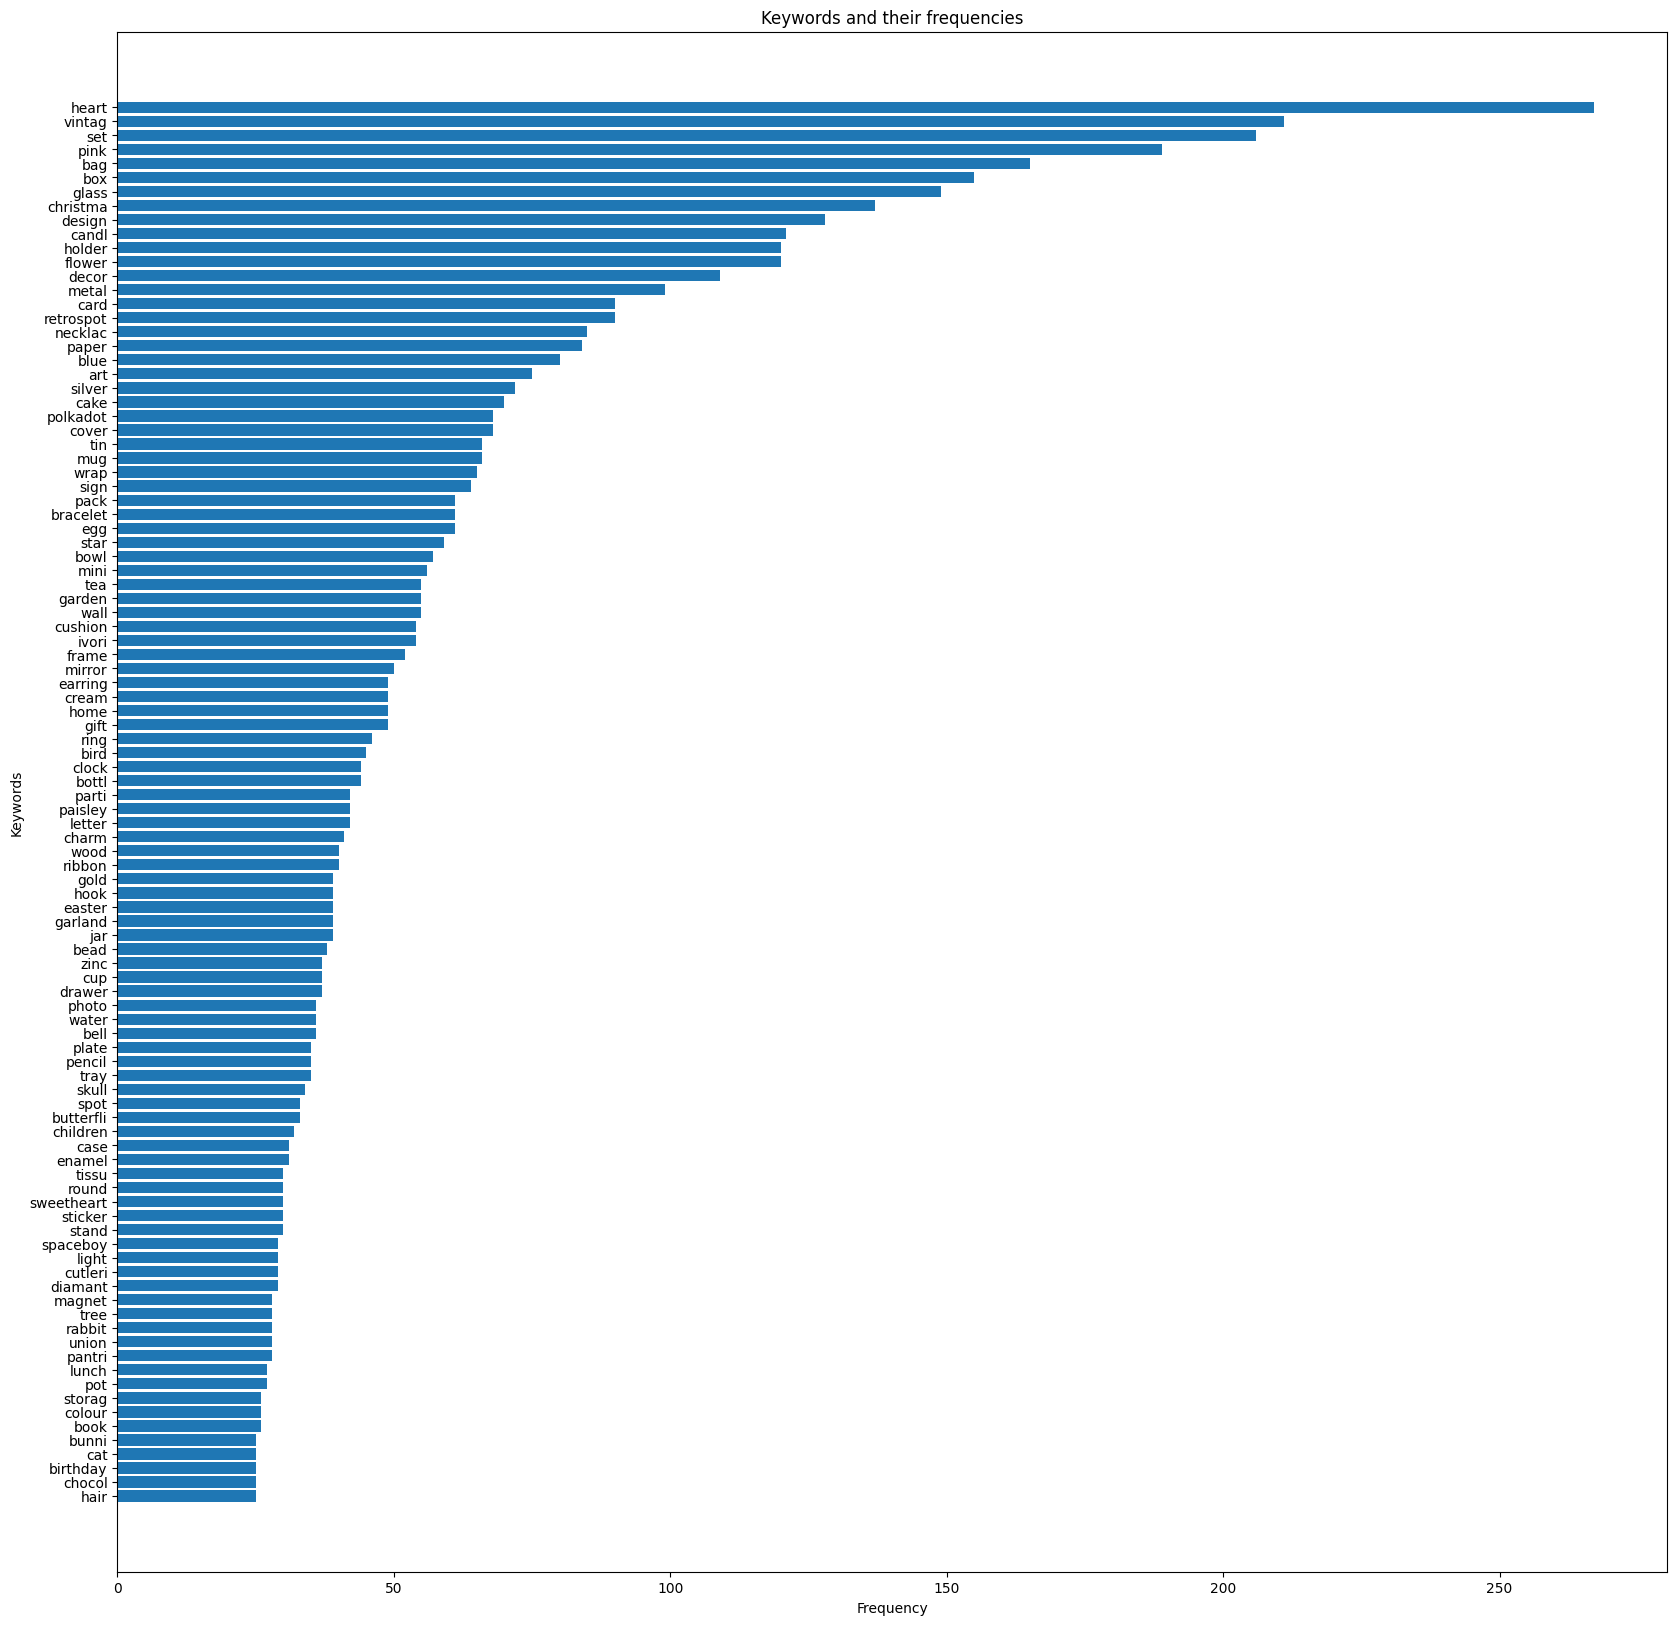

In [24]:
# sort the keywords by their frequencies after converting the count_keywords column to integer  
keywords = keywords.withColumn("count_keywords", keywords["count_keywords"].cast("int")).sort("count_keywords", ascending=False)
keywords.show()

# plot the histogram of the keywords frequencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# convert the PySpark DataFrame to Pandas DataFrame
keywords_pd = keywords.toPandas()

# plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(keywords_pd['category_key'][:100], keywords_pd['count_keywords'][:100])
ax.set_xlabel('Frequency')
ax.set_ylabel('Keywords')
ax.set_title('Keywords and their frequencies')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

In [25]:
# consider only the keywords with frequency greater than 15
keywords_filtered = keywords.filter(keywords['count_keywords'] > 15)

print("Number of keywords: ", keywords_filtered.count())

Number of keywords:  162


In [26]:
count_keywords = keywords_pd['count_keywords'].values.tolist()
keywords_select = keywords_pd['category_key'].values.tolist()

count_keywords = dict(enumerate(count_keywords))
keywords_select = dict(enumerate(keywords_select))

list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print("Number of products: ", len(list_products))

Number of products:  193


### Quantity
The quantities of each product (item) per transaction. Numeric.


In [27]:
df_spark_filtered.select('Quantity').describe().show()

+-------+------------------+
|summary|          Quantity|
+-------+------------------+
|  count|            401603|
|   mean|12.183297933531373|
| stddev|250.28334823423197|
|    min|            -80995|
|    max|             80995|
+-------+------------------+



### CustomerID
*  a 5-digit integral number uniquely assigned to each customer

In [28]:
#get number of unique customers
df_spark_filtered.select('CustomerID').distinct().count()

4372

In [29]:
# group by CustomerID, InvoiceNo, and count the number of rows
from pyspark.sql.functions import count
temp = df_spark_filtered.groupBy('CustomerID', 'InvoiceNo').agg(count('Quantity').alias('Number of products')).orderBy('CustomerID', ascending=True)
temp.show(10)

+----------+---------+------------------+
|CustomerID|InvoiceNo|Number of products|
+----------+---------+------------------+
|   12346.0|   541431|                 1|
|   12346.0|  C541433|                 1|
|   12347.0|   537626|                31|
|   12347.0|   542237|                29|
|   12347.0|   581180|                11|
|   12347.0|   562032|                22|
|   12347.0|   573511|                47|
|   12347.0|   549222|                24|
|   12347.0|   556201|                18|
|   12348.0|   548955|                 5|
+----------+---------+------------------+
only showing top 10 rows



* Invoices starts whit C are cancelled
* there are customers only buy small quantities of products and other customers buy large quantities of products

### InvoiceDate

In [30]:
#min and max date
print(f"the minimum date is: {df_spark_filtered.select('InvoiceDate').agg({'InvoiceDate': 'min'}).collect()[0][0]}")
print(f"the maximum date is: {df_spark_filtered.select('InvoiceDate').agg({'InvoiceDate': 'max'}).collect()[0][0]}")

the minimum date is: 2010-12-01


the maximum date is: 2011-12-09


### Country

In [31]:
number_countries=df_spark_filtered.select('Country').distinct().count()
print(f"Number of countries: {number_countries}")

Number of countries: 37


Sum of invoice counts: 22190


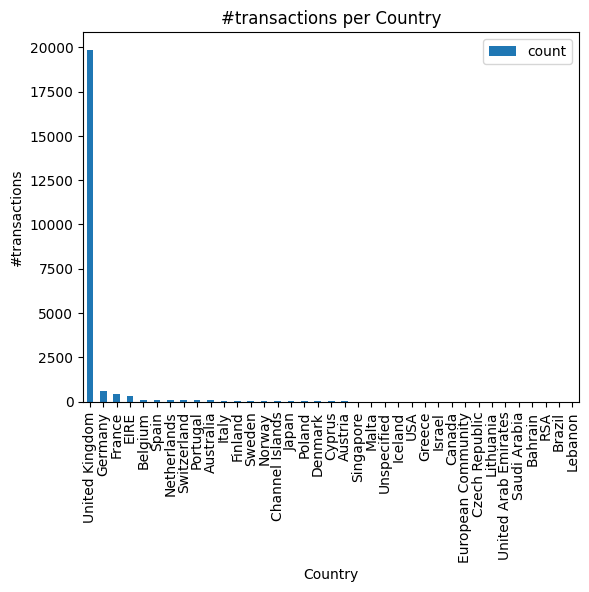

In [32]:
invoice_counts = df_spark_filtered.groupBy(['Country', 'InvoiceNo']).count().groupBy('Country').count().orderBy('count', ascending=False)
#print sum of invoice_counts
print(f"Sum of invoice counts: {invoice_counts.agg({'count': 'sum'}).collect()[0][0]}")
pandas_df = invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("#transactions per Country")
plt.xlabel("Country")
plt.ylabel("#transactions")
plt.show()

Sum of cancelled invoice counts: 3654


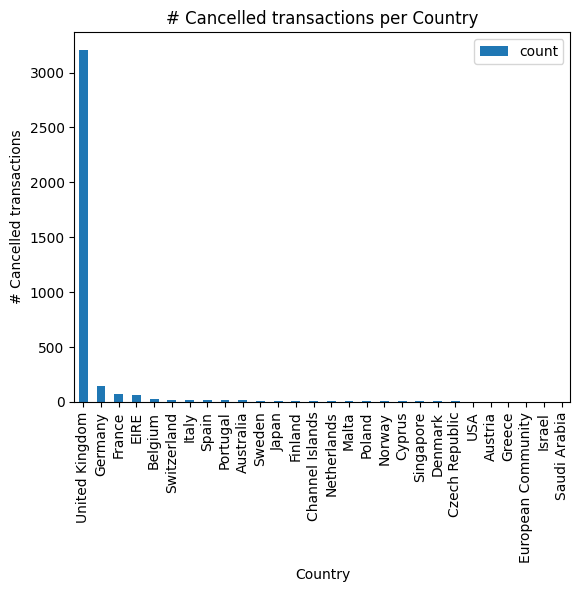

In [33]:
cancelled_invoice_counts = df_spark_filtered.filter(df_spark_filtered['InvoiceNo'].contains('C')).groupBy(['Country', 'InvoiceNo']).count().groupBy('Country').count().orderBy('count', ascending=False)
print(f"Sum of cancelled invoice counts: {cancelled_invoice_counts.agg({'count': 'sum'}).collect()[0][0]}")
pandas_df = cancelled_invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("# Cancelled transactions per Country")
plt.xlabel("Country")
plt.ylabel("# Cancelled transactions")
plt.show()

In [34]:
from pyspark.sql.functions import col
from pyspark.sql.functions import round
df_spark_filtered = df_spark_filtered.withColumn("TotalCost", col("Quantity") * col("UnitPrice"))
df_spark_filtered = df_spark_filtered.withColumn("TotalCost", round(df_spark_filtered.TotalCost, 2))
df_spark_filtered.show(10)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+---------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|TotalCost|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+---------+
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|    20.34|
|   536365|    22752|SET 7 BABUSHKA NE...|       2| 2010-12-01|     7.65|   17850.0|United Kingdom|     15.3|
|   536365|    21730|GLASS STAR FROSTE...|       6| 2010-12-01|     4.25|   17850.0|United Kingdom|     25.5|
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|   17850.0|United Kingdom|     15.3|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|    20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|   17850.0|United Kingdom|     22.0|
|   536365

## Feature Engineering

### Product Returns
* Product returns = count(InvoiceNo starts with c) / count(InvoiceNo) for each customer

In [35]:
from pyspark.sql.functions import count, when
from operator import add

# Map function to emit (customer_id, (is_return, 1)) key-value pairs
def map_func(row):
    customer_id = row['CustomerID']
    invoice_no = row['InvoiceNo']
    is_return = 1 if invoice_no.startswith('C') else 0
    return (customer_id, (is_return, 1))

# Reduce function to aggregate the (is_return, count) values for each customer
def reduce_func(x, y):
    return (x[0] + y[0], x[1] + y[1])

# Apply map function to dataset and reduce by key to get (customer_id, (total_returns, total_transactions)) pairs
customer_returns = df_spark_filtered.select('CustomerID', 'InvoiceNo').distinct().rdd.map(map_func).reduceByKey(reduce_func)
# Calculate product returns for each customer using map function
product_returns = customer_returns.map(lambda x: (x[0], x[1][0] / x[1][1] if x[1][1] > 0 else 0))

# Collect the results as a list of tuples and convert to a PySpark DataFrame
product_returns = spark.createDataFrame(product_returns.collect(), ['CustomerID', 'ProductReturns'])
product_returns.sample(False, 0.001).show()

+----------+--------------+
|CustomerID|ProductReturns|
+----------+--------------+
|   12654.0|           0.0|
|   18037.0|           0.0|
|   14793.0|           0.5|
+----------+--------------+



In [36]:
df_spark_filtered.filter(df_spark_filtered['CustomerID'] == 14792.0).select('InvoiceNo').distinct().show()

+---------+
|InvoiceNo|
+---------+
|   570003|
|  C569954|
+---------+



### Basket Diversity
* Basket diversity = mean(count(unique(StockCode)) per InvoiceNo) for each customer
1. count number of different products in each transaction(invoice) for user 
2. calculate the mean of the previous step for each user

In [37]:
from pyspark.sql.functions import countDistinct, mean

basket_diversity = (df_spark_filtered
                   .groupBy("CustomerID", "InvoiceNo")
                   .agg(countDistinct("StockCode").alias("unique_stock_count"))
                   .groupBy("CustomerID")
                   .agg(mean("unique_stock_count").alias("basket_diversity"))
                   .select("CustomerID", "basket_diversity"))
basket_diversity.sample(False, 0.001).show()

+----------+-----------------+
|CustomerID| basket_diversity|
+----------+-----------------+
|   12585.0|            24.25|
|   14744.0|3.111111111111111|
|   12890.0|             78.0|
|   14652.0|             29.0|
+----------+-----------------+



In [38]:
#get customerID, InvoiceNo, and StockCode
cust=df_spark_filtered.filter(df_spark_filtered['CustomerID'] == 17314.0).distinct().select('CustomerID', 'InvoiceNo', 'StockCode')
#then count number of unique StockCode for each InvoiceNo
cust=cust.groupBy('CustomerID', 'InvoiceNo').agg(countDistinct('StockCode').alias('unique_stock_count'))
cust.show()
#then calculate the mean of unique_stock_count
cust=cust.groupBy('CustomerID').agg(mean('unique_stock_count').alias('basket_diversity'))
cust.show()

+----------+---------+------------------+
|CustomerID|InvoiceNo|unique_stock_count|
+----------+---------+------------------+
|   17314.0|   542641|                 5|
|   17314.0|  C544829|                 2|
|   17314.0|   547885|                 7|
|   17314.0|   557898|                24|
|   17314.0|   575911|                17|
|   17314.0|   576385|                 1|
|   17314.0|   559980|                 8|
|   17314.0|   542786|                21|
|   17314.0|  C548307|                 1|
|   17314.0|  C572482|                 2|
|   17314.0|   570855|                48|
+----------+---------+------------------+



+----------+------------------+
|CustomerID|  basket_diversity|
+----------+------------------+
|   17314.0|12.363636363636363|
+----------+------------------+



### Seasonality
* Seasonality = count(InvoiceNo) per quarter for each customer
* I want column called quarter_one in which there are the number of transactions the user made in quarter one
* I want column called quarter_two in which there are the number of transactions the user made in quarter two
* I want column called quarter_three in which there are the number of transactions the user made in quarter three
* I want column called quarter_three in which four are the number of transactions the user made in quarter four


In [58]:
from pyspark.sql.functions import quarter

#make column that contains the number of unique transactions in quarter1 for each customer
quarter1 = df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 1)
quarter1 = quarter1.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q1'))
quarter2=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 2)
quarter2 = quarter2.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q2'))
quarter3=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 3)
quarter3 = quarter3.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q3'))
quarter4=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 4)
quarter4 = quarter4.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q4'))

quarters = quarter1.join(quarter2, 'CustomerID', 'outer')
quarters = quarters.join(quarter3, 'CustomerID', 'outer')
quarters = quarters.join(quarter4, 'CustomerID', 'outer')
#any null values are replaced with 0
quarters = quarters.na.fill(0)

In [ ]:
#merge quarters and basket_diversity and product_returns with 

In [70]:
copy_filtered = df_spark_filtered.select('*')
print(copy_filtered.count())
copy_filtered=copy_filtered.join(quarters, 'CustomerID', 'outer')
copy_filtered=copy_filtered.join(basket_diversity, 'CustomerID', 'outer')
copy_filtered=copy_filtered.join(product_returns, 'CustomerID', 'outer')

401603


401603


In [88]:
features = copy_filtered.dropDuplicates(['CustomerID'])
# Show the unique rows
print("len:  ",features.count())
features.show(10)

len:   4372


+----------+---------+---------+--------------------+--------+-----------+---------+--------------+---------+----------------------+----------------------+----------------------+----------------------+------------------+------------------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|       Country|TotalCost|unique_transactions_q1|unique_transactions_q2|unique_transactions_q3|unique_transactions_q4|  basket_diversity|    ProductReturns|
+----------+---------+---------+--------------------+--------+-----------+---------+--------------+---------+----------------------+----------------------+----------------------+----------------------+------------------+------------------+
|   12346.0|  C541433|    23166|MEDIUM CERAMIC TO...|  -74215| 2011-01-18|     1.04|United Kingdom| -77183.6|                     2|                     0|                     0|                     0|               1.0|               0.5|
|   12347.0|   537626|    22725|ALARM CL